# Count particles of EPN24-MCP with varying numbers of MS2 tags using Big-FISH

In [1]:
# Note that this uses the "bigfish" conda environment

# Introduction

## Imports

In [2]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
import skimage
import nd2
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from skimage import morphology

## Set output parameters

In [4]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/imaging_EPN24MCP_particles"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [5]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Define pipeline

In [6]:
def load_filter_detect_spots(infile, threshold=None, title=None, do_plot=False):
    
    # Load image
    im = nd2.imread(infile)

    # Filter to remove large objects
    footprint = morphology.disk(5)
    im_tophat = morphology.white_tophat(im, footprint)

    # Detect spots
    spots, threshold = detection.detect_spots(
    images=im_tophat, 
    threshold=threshold,
    return_threshold=True, 
    voxel_size=(107.6, 107.6),  # in nanometer (one value per dimension yx)
    spot_radius=(100, 100))  # in nanometer (one value per dimension yx)

    # Plot detection
    if do_plot:
        plot.plot_detection(im_tophat, spots, rescale=True, contrast=True, color="g", title=title)
        
    n_spots = spots.shape[0]
    
    # Cleanup
    del im
    del im_tophat
    del spots
    
    return n_spots, threshold

# Load sample metadata

In [7]:
infile = "../imaging_data/imaging_EPN24MCP_particles/imaging_EPN24MCP_particles_metadata.csv"

obs = pd.read_csv(infile)

print(obs.shape)
obs.head()

(16, 6)


,Sample,Reporter,n_MS2,n_MS2_pos,fov,path_to_infile
0,EPN24-MCP + mCh-MS2x12,mCh-MS2x12,12,12,1,../imaging_data/imaging_EPN24MCP_particles/Sam...
1,EPN24-MCP + mCh-MS2x12,mCh-MS2x12,12,12,2,../imaging_data/imaging_EPN24MCP_particles/Sam...
2,EPN24-MCP + mCh-MS2x12,mCh-MS2x12,12,12,3,../imaging_data/imaging_EPN24MCP_particles/Sam...
3,EPN24-MCP + mCh-MS2x4,mCh-MS2x4,4,4,1,../imaging_data/imaging_EPN24MCP_particles/Sam...
4,EPN24-MCP + mCh-MS2x4,mCh-MS2x4,4,4,2,../imaging_data/imaging_EPN24MCP_particles/Sam...


In [8]:
# Define columns for data to enter
obs["threshold"] = np.nan
obs["n_spots"] = np.nan

# Set threshold

In [9]:
# Set global threshold to minimize background in negative controls (chosen empirically by varying threshold and examining number of spots detected)
THRESHOLD = 100

## Count spots in each image

In [10]:
%%time

for i, row in obs.iterrows():
    
    infile = row["path_to_infile"]
    title = infile
    
    spots, threshold = load_filter_detect_spots(infile, threshold=THRESHOLD, do_plot=False)
    
    obs.loc[i, "n_spots"] = spots
    
    print("Spots:", spots)
    print()

Spots: 183

Spots: 119

Spots: 242

Spots: 96

Spots: 34

Spots: 42

Spots: 61

Spots: 77

Spots: 131

Spots: 132

Spots: 128

Spots: 142

Spots: 204

Spots: 11

Spots: 7

Spots: 7

CPU times: user 35.6 s, sys: 2.73 s, total: 38.3 s
Wall time: 38.3 s


# Summarize replicates

In [11]:
# Calculate mean and standard deviation across replicates

summary = pd.DataFrame()

summary["n_spots Mean"] = obs.groupby("Sample")["n_spots"].mean()
summary["n_spots STD"] = obs.groupby("Sample")["n_spots"].std()

index_ordered = ["EPN24-MCP + mCh-MS2x12",
                 "EPN24-MCP + mCh-MS2x4",
                 "EPN24-MCP + mCh",
                 "EPN24-MCP",
                 "WT"]
summary = summary.loc[index_ordered]

summary = summary.reset_index()

summary

,Sample,n_spots Mean,n_spots STD
0,EPN24-MCP + mCh-MS2x12,181.333333,61.516935
1,EPN24-MCP + mCh-MS2x4,58.250000,27.596799
2,EPN24-MCP + mCh,113.333333,31.469562
3,EPN24-MCP,158.000000,40.447497
4,WT,8.333333,2.309401


In [12]:
# Calculate abundance relative to reference (EPN24-MCP)
summary = summary.set_index("Sample")

n_spots_ref = summary.loc["EPN24-MCP + mCh-MS2x12", "n_spots Mean"]
summary["n_spots relative to ref"] = summary["n_spots Mean"] / n_spots_ref
summary["n_spots STD relative to ref"] = summary["n_spots STD"] / n_spots_ref

summary = summary.reset_index()

summary

,Sample,n_spots Mean,n_spots STD,n_spots relative to ref,n_spots STD relative to ref
0,EPN24-MCP + mCh-MS2x12,181.333333,61.516935,1.000000,0.339248
1,EPN24-MCP + mCh-MS2x4,58.250000,27.596799,0.321232,0.152188
2,EPN24-MCP + mCh,113.333333,31.469562,0.625000,0.173545
3,EPN24-MCP,158.000000,40.447497,0.871324,0.223056
4,WT,8.333333,2.309401,0.045956,0.012736


# Plot relative particle abundance with varying MS2

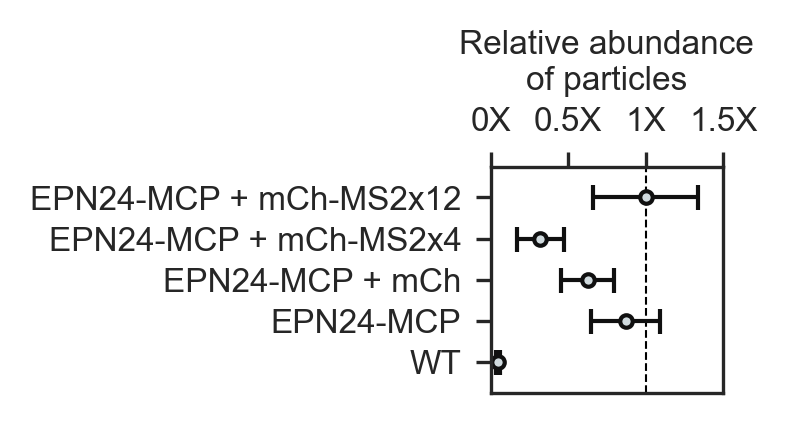

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.errorbar(x=summary["n_spots relative to ref"],
            y=range(summary.shape[0])[::-1],
            xerr=summary["n_spots STD relative to ref"],
            ls="",
            marker="o",
            color="#d0dade",
            markersize=3,
            markeredgecolor="#101010",
            markeredgewidth=1,
            ecolor="#101010",
            elinewidth=1,
            capsize=3,
            )

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlim(0, 1.5)
ax.set_ylim(-0.75, 4.75)

ax.set_xlabel("Relative abundance\nof particles")
ax.set_ylabel("")

ax.set_xticks([0, 0.5, 1, 1.5])
ax.set_xticklabels(["0X", "0.5X", "1X", "1.5X"])

ax.set_yticks([0, 1, 2, 3, 4])
yticklabels = summary["Sample"][::-1]
ax.set_yticklabels(yticklabels)

ax.axvline(1, ls="--", lw=0.5, color="k", zorder=-1)

save_figure(fig, "scatterplot_relative_abundance_of_particles_with_varying_MS2")